# ATE I: Binary treatment

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from SyncRNG import SyncRNG
import patsy
%matplotlib inline
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pyreadr
import seaborn as sns
import random
import string
import warnings
warnings.filterwarnings("ignore")

## Notation and definitions

Let's establish some notation. Each data point will be defined by the triple $(X_i, W_i, Y_i)$. The vector $X_i$ represents covariates that are observed for individual $i$. Treatment assignment is indicated by $W_i \in \{0, 1\}$, with 1 representing treatment, and 0 representing control. The scalar $Y_i$ is the observed outcome, and it can be real or binary. Each observation is drawn independently and from the same distribution. We'll be interested in assessing the causal effect of treatment on outcome. 

A difficulty in estimating causal quantities is that we observe each individual in only one treatment state: either they were treated, or they weren't. However, it's often useful to imagine that each individual is endowed with two random variables $(Y_i(1), Y_i(0))$, where $Y_i(1)$ represents the value of this individual's outcome if they receive treatment, and $Y_i(0)$ represents their outcome if they are not treated. These random variables are called  **potential outcomes**. The observed outcome $Y_i$ corresponds to whichever potential outcome we got to see:

$$
  Y_i \equiv Y_i(W_i) =
  \begin{cases}
    Y_i(1) \qquad \text{if }W_i = 1 \text{ (treated)} \\ 
    Y_i(0) \qquad \text{if }W_i = 0 \text{ (control)}\\ 
  \end{cases}
$$

Since we can't observe both $Y_i(1)$ and $Y_i(0)$, we won't be able to make statistical claims about the individual treatment effect $Y_i(1) - Y_i(0)$. Instead, our goal will be to estimate the **average treatment effect (ATE)**:

$$
  \tau := \mathbf{E}[Y_i(1) - Y_i(0)].
$$ (ate)

Here, when we refer to the **randomized** setting we mean that we have data generated by a randomized control trial. The key characteristic of this setting is that the probability that an individual is assigned to the treatment arm is fixed. In particular, it does not depend on the individual's potential outcomes:

$$
  Y_i(1), Y_i(0) \perp W_i.
$$ (unconf)

This precludes situations in which individuals may self-select into or out of treatment. The canonical failure example is a job training program in which workers enroll more often if they are more likely to benefit from treatment because in that case $W_i$ and $Y_i(1) - Y_i(0)$ would be positively correlated.

When condition {eq}`unconf` is violated, we say that we are in an **observational** setting. This is a more complex setting encompassing several different scenarios: sometimes it's still possible to estimate the ATE under additional assumptions, sometimes the researcher can exploit other sources of variation to obtain other interesting estimands. Here, we will focus on ATE estimation under the following assumption: 

$$
  Y_i(1), Y_i(0) \perp W_i \ | \ X_i.
$$ (unconf_1)

In this document we will call this assumption **unconfoundeness**, though it is also known as **no unmeasured confounders**, **ignorability** or **selection on observables**. It says that all possible sources of self-selection, etc., can be explained by the observable covariates $X_i$. Continuing the example above, it may be that older or more educated are more likely to self-select into treatment; but when we compare two workers that have the same age and level of education, etc., there's nothing else that we could infer about their relative potential outcomes if we knew that one went into job training and the other did not.

As we'll see below, a key quantity of interest will be the treatment assignment probability, or **propensity score** $e(X_i) := \mathbb{P}[W_i = 1 | X_i]$. In an experimental setting this quantity is usually known and fixed, and in observational settings it must be estimated from the data. We will often need to assume that the propensity score is bounded away from zero and one. That is, there exists some $\eta > 0$ such that

$$
  \eta < e(x) < 1 - \eta  \qquad \text{for all }x.
$$ (overlap)

This assumption is known as **overlap**, and it means that for all types of people in our population (i.e., all values of observable characteristics) we can find some portion of individuals in treatment and some in control. Intuitively, this is necessary because we'd like to will be comparing treatment and control at each level of the covariates and then aggregate those results.

As a running example, in what follows we'll be using an abridged version of a public dataset from the General Social Survey (GSS) [(Smith, 2016)](https://gss.norc.org/Documents/reports/project-reports/GSSProject%20report32.pdf). The setting is a randomized control trial. Individuals were asked about their thoughts on government spending on the social safety net. The treatment is the wording of the question: about half of the individuals were asked if they thought government spends too much on "welfare" $(W_i = 1)$, while the remaining half was asked about "assistance to the poor" $(W_i = 0)$. The outcome is binary, with $Y_i = 1$ corresponding to a positive answer. In the data set below, we also collect a few other demographic covariates.


In [2]:
# Read in data
data = pd.read_csv( "https://docs.google.com/uc?id=1kSxrVci_EUcSr_Lg1JKk1l7Xd5I9zfRC&export=download" )
n = data.shape[0]

# Treatment: does the the gov't spend too much on "welfare" (1) or "assistance to the poor" (0)
treatment = "w"

# Outcome: 1 for 'yes', 0 for 'no'
outcome = "y"

# Additional covariates
covariates = ["age", "polviews", "income", "educ", "marital", "sex"]

## Difference-in-means estimator

Let's begin by considering a simple estimator that is available in experimental settings. The **difference-in-means** estimator is the sample average of outcomes in treatment minus the sample average of outcomes in control.

$$
  \widehat{\tau}^{DIFF} =
    \frac{1}{n_1} \sum_{i:W_i = 1} Y_i -
    \frac{1}{n_0} \sum_{i:W_i = 0} Y_i
    \qquad \text{where} \qquad
    n_w := |\{i : W_i = w \}|
$$ (ate-dm)

Here’s one way to compute the difference-in-means estimator and its associated statistics (t-stats, p-values, etc.) directly:

In [3]:
# Only valid in the randomized setting. Do not use in observational settings.
Y = data.loc[ : , outcome ].copy()
W = data.loc[ : , treatment ].copy()
ate_est = Y[ W == 1 ].mean() - Y[ W == 0 ].mean()
ate_se = np.sqrt(( Y[ W == 1 ].var() / (W == 1).sum() ) + ( Y[ W == 0 ].var() / (W == 0).sum() ))
ate_tstat = ate_est / ate_se
ate_pvalue = 2* norm.cdf( 1 - abs( ate_est / ate_se ) )
ate_results = pd.DataFrame( { "estimate" : [ate_est], 
               "std_error" : [ate_se], 
               "t_stat" : [ate_tstat], 
               "pvalue" : [ate_pvalue] } )
ate_results

,estimate,std_error,t_stat,pvalue
0,-0.347116,0.004896,-70.903029,0.0


Or, alternatively, via the `t.test` function:

In [4]:
stats.ttest_ind(a=Y[ W == 1 ] , b = Y[ W == 0 ] , equal_var=False)

Ttest_indResult(statistic=-70.90302895777103, pvalue=0.0)

We can also compute the same quantity via linear regression, using the fact that

$$
  Y_i = Y_i(0) + W_i \left( Y_i(1) - Y_i(0) \right),
$$

so that taking expectations conditional on treatment assignment,

$$
  \mathbf{E}[Y_i | W_i] = \alpha + W_i \tau \qquad \text{where}
  \qquad \alpha := \mathbf{E}[Y_i(0)]
$$

<font size=1>
Exercise: make sure you understand this decomposition. Where is the unconfoundedness assumption (3.2) used?
</font>

This result implies that we can estimate the ATE of a binary treatment via a linear regression of observed outcomes $Y_i$ on a vector consisting of intercept and treatment assignment $(1, W_i)$.

In [5]:
# Do not use! standard errors are not robust to heteroskedasticity! (See below)
fmla = outcome + "~" + treatment
ols = smf.ols( fmla, data )
ols.fit().summary2().tables[1].iloc[1, :4]

Coef.       -0.347116
Std.Err.     0.004732
t          -73.349622
P>|t|        0.000000
Name: w, dtype: float64

The point estimate we get is the same as we got above by computing the ATE "directly" via `mean(Y[W==1]) - mean(Y[W==0])`. However, the standard errors are different. This is because in `R` the command `lm` does not compute heteroskedasticity-robust standard errors. This is easily solvable.


In [6]:
# Use this instead. Standard errors are heteroskedasticity-robust.
# Only valid in randomized setting.
fmla = outcome + "~" + treatment
ols = smf.ols( fmla, data )
ols.fit().get_robustcov_results(cov_type = "HC2").summary2().tables[1].iloc[1, :4]

Coef.       -0.347116
Std.Err.     0.004896
t          -70.903029
P>|t|        0.000000
Name: w, dtype: float64

The difference-in-means estimator is a simple, easily computable, unbiased, "model-free" estimator of the treatment effect. It should always be reported when dealing with experimental data. However, as we'll see later in this chapter, it may not necessarily be the one with smallest variance.

## Turning an experimental dataset into an observational one 

In what follows we'll purposely create a biased sample to show how the difference in means estimator fails in observational settings. We'll focus on two covariates: `age` and political views (`polviews`). Presumably, younger or more liberal individuals are less affected by the change in wording in the question. So let's see what happens when we make these individuals more prominent in our sample of treated individuals, and less prominent in our sample of untreated individuals.

In [7]:
# Probabilistically dropping observations in a manner that depends on x

# copying old dataset, just in case
data_exp = data.copy()
data.shape

# defining the group that we will be dropped with some high probability
grp = ((data.w == 1) & ((data.age > 45) | (data.polviews < 5) )) | \
        ((data.w == 0) &  # if untreated AND
        (
            (data.age < 45) |   # belongs a younger group OR
            (data.polviews > 4)  # more liberal
        )) 



grp.sum()

# Individuals in the group above have a small chance of being kept in the sample
prob = grp.apply(lambda x: 0.15 if x == True else 0.85 ).tolist()
keep_idx = list( map( bool, [ np.random.binomial( 1 , p , data.shape[0] )[0] for p in prob ] )  )

# Dropping
data = data.loc[ keep_idx , : ].copy()
data.shape
np.array(keep_idx).mean()

0.31190451261647995


Let's see what happens to our sample before and after the change. This next figure shows the original dataset. Each observation is represented by a point on either the left or right scatterplots. An outcome of $Y_i=1$ is denoted by a blue circle, and $Y_i=0$ is denoted by a red square, but let's not focus on the outcome at the moment. For now, what's important to note is that the covariate distributions for treated and untreated populations are very similar. This is what we should expect in an experimental setting under unconfoundedness.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


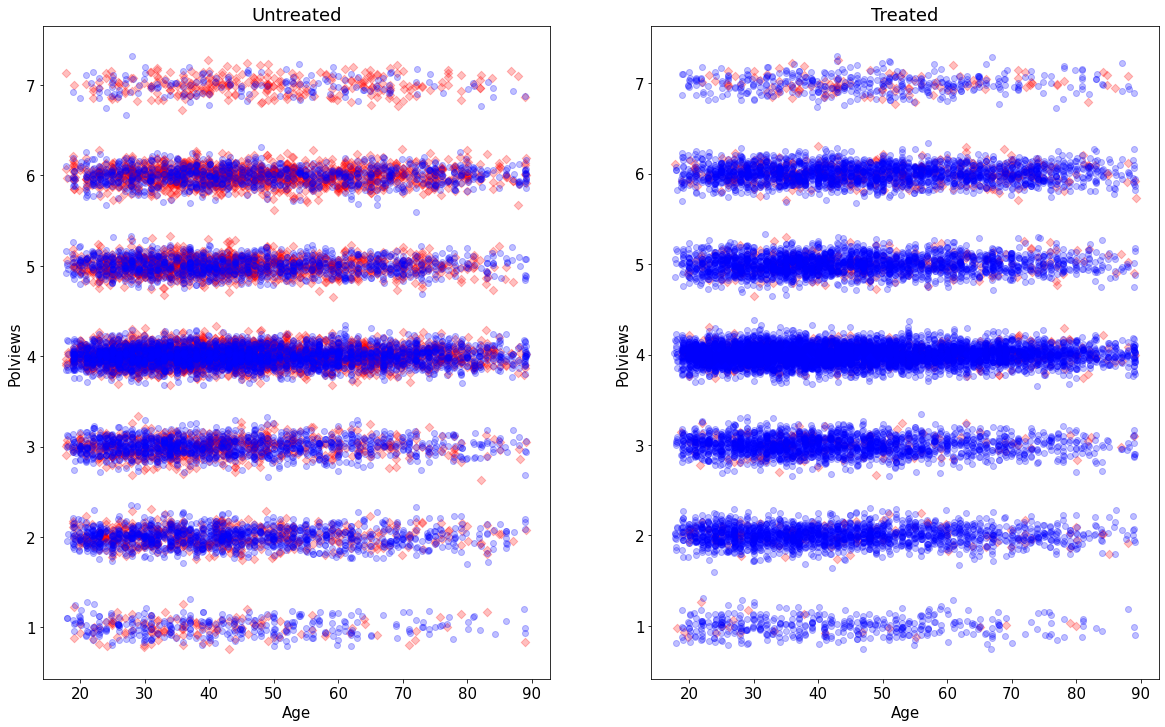

In [8]:
y1, X = patsy.dmatrices( " y ~ 0 + age + polviews" , data_exp , return_type='matrix')

W = data_exp.w.to_numpy()
Y = data_exp.y.to_numpy()

matplotlib.rcParams['figure.figsize'] = [50, 60]
matplotlib.rcParams.update({'font.size': 15})
fig, axes = plt.subplots( 1 , 2 , figsize = ( 20 , 12 ) )

for w in range(2):
    x2 = X[ W == w , 0] + np.random.normal( scale = 0.1 , size = sum( W ==w ) )
    y2 = X[ W == w , 1] + np.random.normal( scale = 0.1 , size = sum( W ==w ) )
    axes[ w ].scatter( 
                    x2[ Y[ W == w ] == 1] , y2[ Y[ W == w ] == 1] , 
                    marker = "D", c = (1,0,0,1/4), 
                    facecolors = (1,0,0,1/4)
                )
    axes[ w ].scatter( 
                    x2[ Y[ W == w ] == 0] , y2[ Y[ W == w ] == 0] , 
                    marker = "o", c = (0,0,1,1/4), 
                    facecolors = (0,0,1,1/4)
                )
    axes[ w ].set_xlabel('Age')
    axes[ w ].set_ylabel('Polviews')
    axes[ w ].set_title( f'{"Treated" if w == 1 else "Untreated"}')

On the other hand, this is what the modified dataset looks like. The treated population is much younger and more liberal, while the untreated population is older and more conservative.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


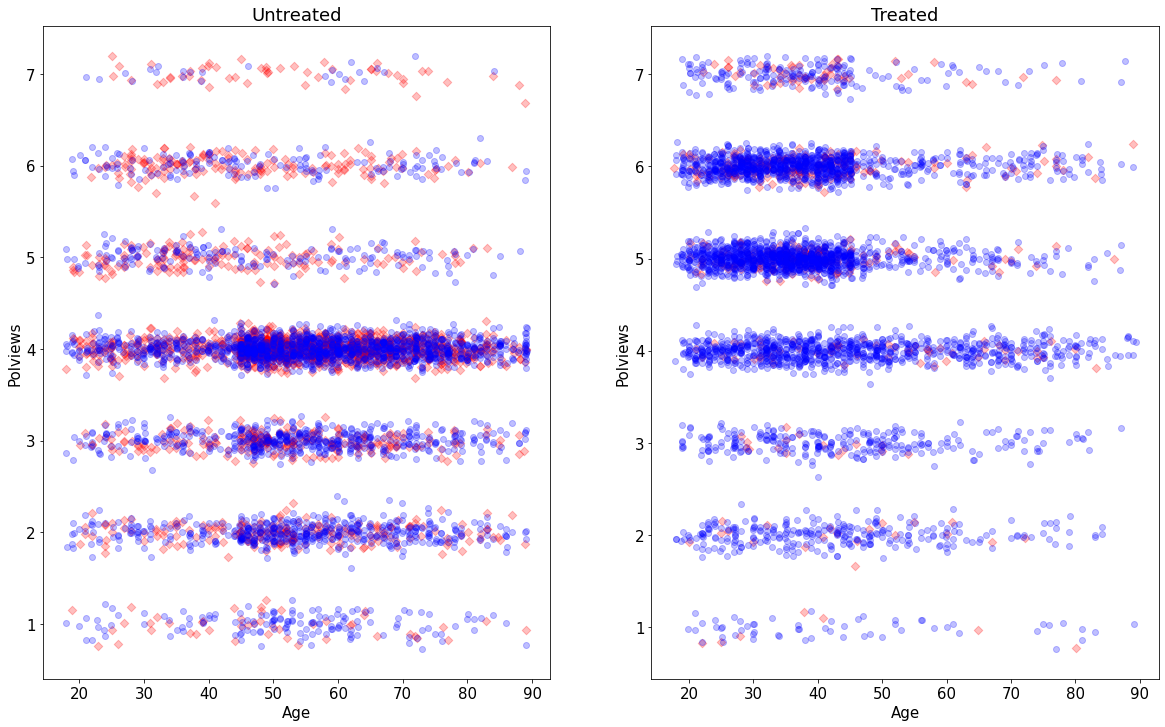

In [9]:
y1, X = patsy.dmatrices( " y ~ 0 + age + polviews" , data , return_type='matrix')

W = data.w.to_numpy()
Y = data.y.to_numpy()

matplotlib.rcParams['figure.figsize'] = [50, 60]
matplotlib.rcParams.update({'font.size': 15})
fig, axes = plt.subplots( 1 , 2 , figsize = ( 20 , 12 ) )

for w in range(2):
    x2 = X[ W == w , 0] + np.random.normal( scale = 0.1 , size = sum( W ==w ) )
    y2 = X[ W == w , 1] + np.random.normal( scale = 0.1 , size = sum( W ==w ) )
    axes[ w ].scatter( 
                    x2[ Y[ W == w ] == 1] , y2[ Y[ W == w ] == 1] , 
                    marker = "D", c = (1,0,0,1/4), 
                    facecolors = (1,0,0,1/4)
                )
    axes[ w ].scatter( 
                    x2[ Y[ W == w ] == 0] , y2[ Y[ W == w ] == 0] , 
                    marker = "o", c = (0,0,1,1/4), 
                    facecolors = (0,0,1,1/4)
                )
    axes[ w ].set_xlabel('Age')
    axes[ w ].set_ylabel('Polviews')
    axes[ w ].set_title( f'{"Treated" if w == 1 else "Untreated"}')

As we would expect the difference-in-means estimate is biased toward zero because in this new dataset we mostly treated individuals for which we expect the effect to be smaller. 


In [10]:
# Do not use in observational settings.
# This is only to show how the difference-in-means estimator is biased in that case.
fmla = outcome + "~" + treatment
ols = smf.ols( fmla, data )
ols.fit().get_robustcov_results(cov_type = "HC2").summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,0.400642,0.007168,55.895800,0.000000e+00,0.386591,0.414692
w,-0.289661,0.008633,-33.552375,1.455847e-232,-0.306584,-0.272738


Note that the dataset created above still satisfies unconfoundedness {eq}`unconf_1`, since discrepancies in treatment assignment probability are described by observable covariates (`age` and `polviews`). Moreover, it also satisfies the overlap assumption {eq}`overlap`, since never completely dropped all treated or all untreated observations in any region of the covariate space. This is important because, in what follows, we'll consider different estimators of the ATE that are available in observational settings under unconfoundedness and overlap.


## Direct estimation

Our first estimator is suggested by the following decomposition of the ATE, which is possible due to unconfoundedness {eq}`unconf_1`.

$$
  \mathbf{E}[Y_i(1) - Y_i(0)]
  = \mathbf{E}[\mathbf{E}[Y_i | X_i, W_i=1]] - \mathbf{E}[\mathbf{E}[Y_i | X_i, W_i=0]]
$$

<font size=1>
[Exercise: make sure you understand this. Where is the unconfoundedness assumption used?]
</font>

The decomposition above suggests the following procedure, sometimes called the **direct estimate** of the ATE:

1. Estimate $\mu(x, w) := \mathbf{E}[Y_i|X_i = x,W_i=w]$, preferably using nonparametric methods.
2. Predict $\hat{\mu}(X_i, 1)$ and $\hat{\mu}(X_i, 0)$ for each observation in the data.
3. Average out the predictions and subtract them.

$$
  \hat{\tau}^{DM} := \frac{1}{n} \sum_{i=1}^{n} \hat{\mu}(X_i, 1) - \hat{\mu}(X_i, 0)
$$

In [11]:
# Do not use! We'll see a better estimator below.

# Fitting some model of E[Y|X,W]
model = smf.ols("y ~ bs(age, df = 3) * w + bs(polviews, df = 3) * w + bs(income, df = 3) * w + bs(educ, df = 3) * w + bs(marital, df = 3) * w + bs(sex, df = 3) * w", data).fit()
data_aux = data.copy()

# Predicting E[Y|X,W=w] for w in {0, 1}
data_1 = data_aux.copy()
data_1.loc[ : , treatment] = 1
data_0 = data_aux.copy()
data_0.loc[ : , treatment] = 0
muhat_treat = model.predict( data_1 ) 
muhat_ctrl = model.predict( data_0 )

# Averaging predictions and taking their difference
ate_est = muhat_treat.mean() - muhat_ctrl.mean()
print(ate_est)

-0.34263206499331667


This estimator allows us to leverage regression techniques to estimate the ATE, so the resulting estimate should have smaller root-mean-squared error. However, it has several disadvantages that make it undesirable. First, its properties will rely heavily on the model  $\hat{\mu}(x, w)$ being correctly specified: it will be an unbiased and/or consistent estimate of the ATE provided that $\hat{\mu}(x, w)$  is an unbiased and/or consistent estimator of  $\mathbf{E}[Y|X=x, W=w]$. In practice, having a well-specified model is not something we want to rely upon. In general, it will also not be asymptotically normal, which means that we can’t easily compute t-statistics and p-values for it.


A technical note. Step 1 above can be done by regressing $Y_i$ on $X_i$ using only treated observations to get an estimate $\hat{\mu}(x, 1)$ first, and then repeating the same to obtain $\hat{\mu}(x, 0)$ from the control observations. Or it can be done by regression $Y_i$ on both covariates $(X_i, W_i)$ together and obtaining a function $\hat{\mu}(x, w)$. Both have advantages and disadvantages, and we refer to [Künzel, Sekhon, Bickel, Yu  (2019)](https://www.pnas.org/content/116/10/4156.short) for a discussion.

## Inverse propensity-weighted estimator

To understand this estimator, let's first consider a toy problem. Suppose that we'd like to estimate the average effect of a certain learning intervention on students' grades, measured on a scale of 0-100. We run two separate experiments in schools of type A and B. Suppose that, unknown to us, grades among treated students in schools of type A are approximately distributed as $Y_i(1) | A \sim N(60, 5^2)$, whereas in schools of type B they are distributed as $Y_i(1) | B \sim N(70, 5^2)$. Moreover, for simplicity both schools have the same number of students. If we could treat the same number of students in both types of schools, we'd get an unbiased estimate of the population mean grade among treated individuals: $(1/2)60 + (1/2)70 = 75$.

However, suppose that enrollment in the treatment is voluntary. In school A, only 5\% enroll in the study, whereas in school B the number is 40\%. Therefore, if we take an average of treated students' grades without taking school membership into account, school B's students would be over-represented, and therefore our estimate of treated student's grades would be biased upward.


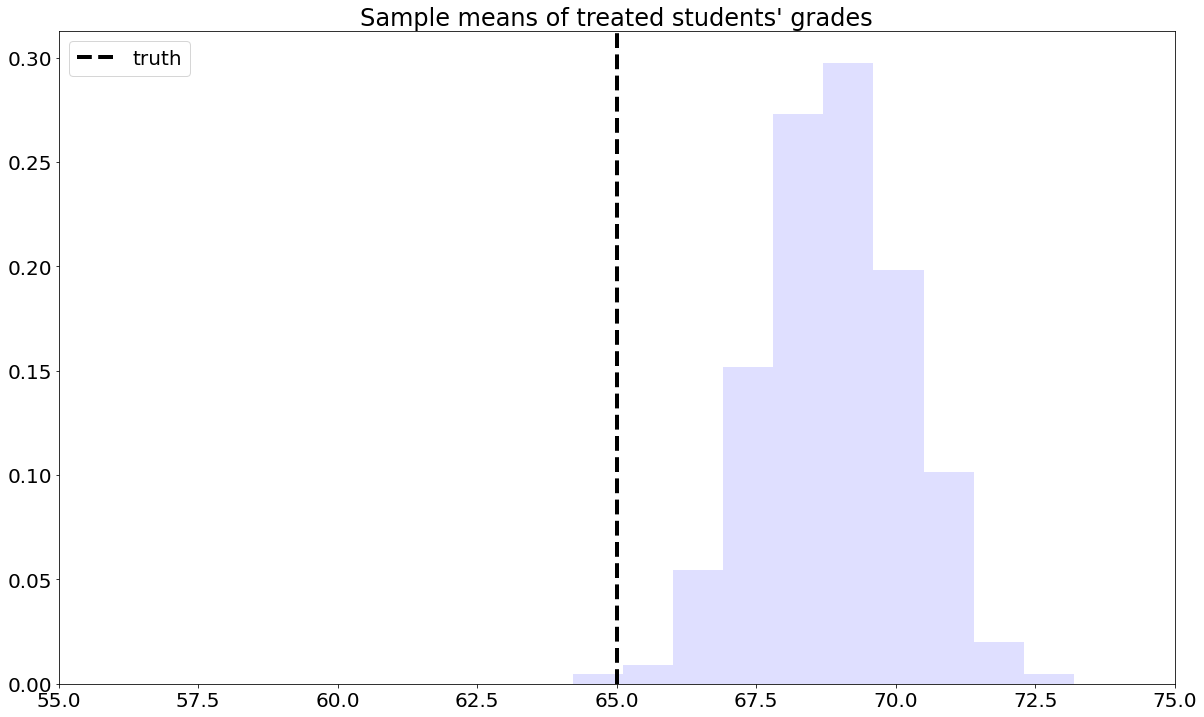

In [12]:
# Simulating the scenario above a large number of times
A_mean = 60
B_mean = 70
pop_mean = 0.5 * A_mean + 0.5 * B_mean  # both schools have the same size

# simulating the scenario about a large number of times
def mean_school():
    school = np.random.choice([ "A", "B" ], size=100, replace=True, p=[0.5, 0.5])

    t_true = np.random.binomial( 1 , 0.05 , 100 )
    t_false = np.random.binomial( 1 , 0.4 , 100 )
    treated = np.zeros_like( school, dtype = float )
    for i in range( school.size ):
        if school[ i ] == "A":
            treated[ i ] = t_true[ i ]
        else:
            treated[ i ] = t_false[ i ]

    g_true = np.random.normal( loc = A_mean , scale = 5 , size = 100 )
    g_false = np.random.normal( loc = B_mean , scale = 5 , size = 100 )
    grades = np.zeros_like( school, dtype = float )
    for i in range( school.size ):
        if school[ i ] == "A":
            grades[ i ] = g_true[ i ]
        else:
            grades[ i ] = g_false[ i ]    

    return np.mean( grades[ treated == 1 ] )

sample_means = np.array([mean_school() for _ in range( 1000 )])

matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams.update({'font.size': 20})
fig, axes = plt.subplots( 1 , 1 , figsize = ( 20 , 12 ) )
axes.hist( sample_means, density = True , color = (0,0,1,1/8) )
axes.set_xlim([ 55, 75 ])
axes.set_title( "Sample means of treated students' grades" )
axes.axvline( pop_mean , linestyle = "dashed" , linewidth = 4, c= "black" , label = "truth")
axes.legend(loc='upper left')

To solve this problem, we can consider each school separately, and then aggregate the results. Denote by $n_A$ the number of students from school $A$, and $n_{A,1}$ denote the number of treated students in that school. Likewise, denote by $n_B$ and $n_{B,1}$ the same quantities for school $B$. Then our aggregated means estimator can be written as:

$$ 
  \overbrace{
  {\left (\frac{n_{A}}{n} \right)}
  }^{\text{Proportion of A}}
  \underbrace{
  \frac{1}{n_{A, 1}} \sum_{\substack{i \in A \\ i \text{ treated}}} Y_i
  }_{\text{avg. among treated in A}}
  +
 \overbrace{
 {\left (\frac{n_{B}}{n} \right)}
 }^{\text{Proportion of B}}
 \underbrace{
  \frac{1}{n_{B, 1}} \sum_{\substack{i \in B \\ i \text{ treated}}} Y_i
  }_{\text{avg. among treated in B}}.
$$ (agg)

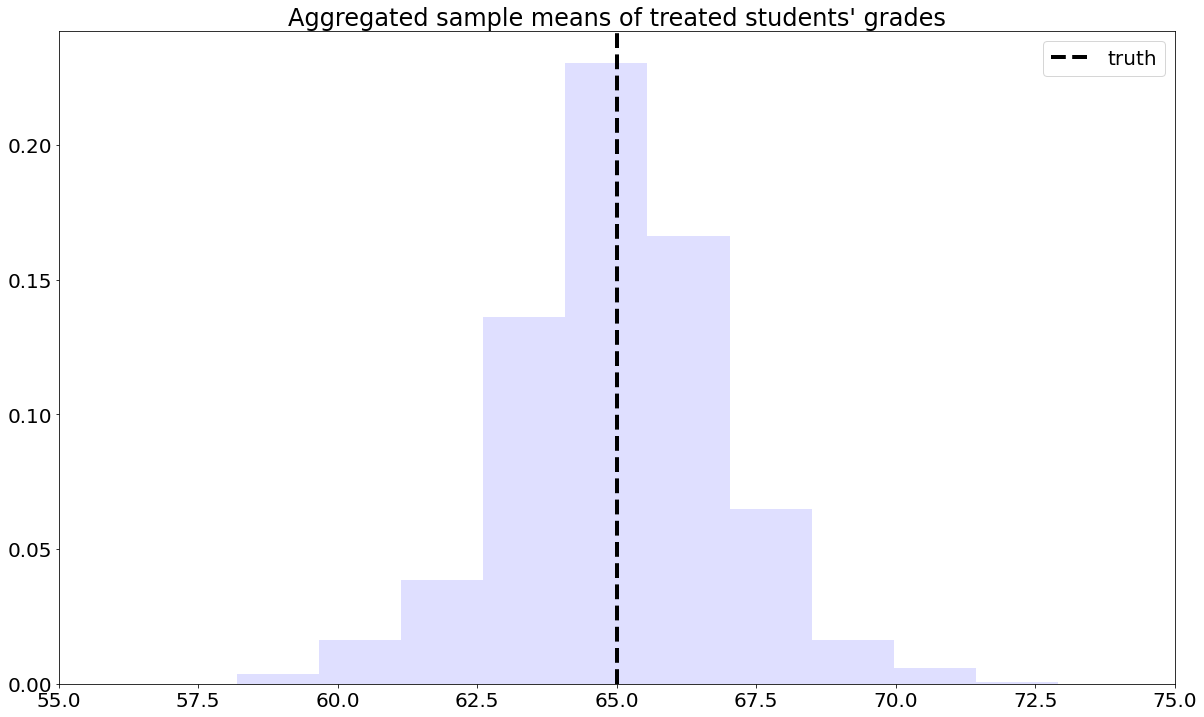

In [13]:
# simulating the scenario about a large number of times
def agg_mean_school():
    school = np.random.choice([ "A", "B" ], size=100, replace=True, p=[0.5, 0.5])

    t_true = np.random.binomial( 1 , 0.05 , 100 )
    t_false = np.random.binomial( 1 , 0.4 , 100 )
    treated = np.zeros_like( school, dtype = float )
    for i in range( school.size ):
        if school[ i ] == "A":
            treated[ i ] = t_true[ i ]
        else:
            treated[ i ] = t_false[ i ]

    g_true = np.random.normal( loc = A_mean , scale = 5 , size = 100 )
    g_false = np.random.normal( loc = B_mean , scale = 5 , size = 100 )
    grades = np.zeros_like( school, dtype = float )
    for i in range( school.size ):
        if school[ i ] == "A":
            grades[ i ] = g_true[ i ]
        else:
            grades[ i ] = g_false[ i ]
            
    mean_treated_A = np.mean(grades[(treated == 1) & (school == 'A')])
    mean_treated_B = np.mean(grades[(treated == 1) & (school == 'B')])
    # probability of belonging to each school
    prob_A = np.mean(school == 'A')
    prob_B = np.mean(school == 'B')
    result = prob_A * mean_treated_A + prob_B * mean_treated_B
    
    return result

agg_means = np.array([agg_mean_school() for _ in range( 1000 )])

matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams.update({'font.size': 20})
fig, axes = plt.subplots( 1 , 1 , figsize = ( 20 , 12 ) )
axes.hist( agg_means, density = True , color = (0,0,1,1/8) )
axes.set_xlim([ 55, 75 ])
axes.set_title( "Aggregated sample means of treated students' grades" )
axes.axvline( pop_mean , linestyle = "dashed" , linewidth = 4, c= "black" , label = "truth")
axes.legend(loc='upper right')

Next, we'll manipulate the expression {eq}`agg`. This next derivation can be a bit overwhelming, but please keep in mind that we're simply doing algebraic manipulations, as well as establishing some common and useful notation. First, note that we can rewrite the average for school A in {eq}`agg` as

$$
    \left (\frac{1}{n_{A, 1}}\right) 
    \sum_{\substack{i \in A \\ i \text{ treated}}} Y_i
    =
    \frac{1}{n_A} \sum_{\substack{i \in A \\ i \text{ treated}}} \frac{1}{(n_{A,1} / n_A)} Y_i
    =
    \frac{1}{n_A} \sum_{i \in A} \frac{W_i}{(n_{A,1} / n_A)} Y_i,
$$ (avg1)

where $W_i$ is the treatment indicator. Plugging {eq}`avg1` back into {eq}`agg`,

$$
  \left ({\frac{n_{A}}{n}}\right) 
    \frac{1}{n_A} \sum_{i \in A} \frac{W_i}{(n_{A,1} / n_A)} Y_i
  +
 \left ({\frac{n_{B}}{n}}\right) 
\frac{1}{n_B} \sum_{i \in B} \frac{W_i}{(n_{B,1} / n_B)} Y_i.
$$

Note that the $n_A$ and $n_B$ will cancel out. Finally, if we denote the sample proportion of treated students in school $A$ by $\hat{e}(A_i) \approx n_{A,1}/n_A$ and similar for school $B$, {eq}`agg` can be written compactly as

$$
  \frac{1}{n} \sum_{i=1}^{n}  \frac{W_i}{\hat{e}(X_i)} Y_i,
$$ (ipw-treated)

where $X_i \in \{A, B\}$ denotes the school membership. Quantity $\hat{e}(X_i)$ is an estimate of the probability of treatment given the control variable $e(X_i) = \mathbb{P}[W_i=1 | X_i ]$, also called the **propensity score**. Because {eq}`ipw-treated` is a weighted average with weights $W_i/\hat{e}(X_i)$, when written in this form we say that it is an **inverse propensity-weighted estimator** (IPW).

The IPW estimator is also defined for the case of continuous covariates. In that case, we must estimate the assignment probability given some model, for example using logistic regression, forests, etc. With respect to modeling, the behavior of the IPW estimator is similar to the direct estimator: if $\hat{e}(X_i)$ is an unbiased estimate of $e(X_i)$, then {eq}`ipw-treated` is an unbiased estimate of $E[Y(1)]$; and we can show that if $\hat{e}(X_i)$ is a consistent estimator of $e(X_i)$, then {eq}`ipw-treated` is consistent for $E[Y(1)]$. 

Another important point is that when the estimated treatment propensity $\hat{e}(X_i)$ is small, the summands in {eq}`ipw-treated` can be very large. In particular, if $\hat{e}(x)$ is exactly zero, then this estimator is undefined. That is why, in addition to requiring conditional unconfoundedness {eq}`unconf_1`, it also requires the overlap condition {eq}`overlap`. In any case, when overlap is small (i.e., $\hat{e}(x)$ is very close to zero for many $x$), IPW becomes an unattractive estimator due to its high variance. We'll see in the next section an improved estimator that builds upon IPW but is strictly superior and should be used instead.

Finally, we just derived an estimator of the average treated outcome, but we could repeat the argument for control units instead. Subtracting the two estimators leads to the following inverse propensity-weighted estimate of the treatment effect:

$$
  \widehat{\tau}^{IPW} := \frac{1}{n} \sum_{i=1}^{n} Y_i \frac{W_i}{\hat{e}(X_i)} - \frac{1}{n} \sum_{i=1}^{n} Y_i \frac{(1 - W_i) }{1-\hat{e}(X_i)}.
$$

The argument above suggests the following algorithm:

1. Estimate the propensity scores $e(X_i)$ by regressing $W_i$ on $X_i$, preferably using a non-parametric method. 
2. Compute the IPW estimator summand:

$$Z_i = Y_i \times \left(\frac{W_i}{\hat{e}(X_i)} - \frac{(1-W_i)}{(1-\hat{e}(X_i)} \right)$$ 

3. Compute the mean and standard error of the new variable $Z_i$

In [14]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import itertools
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_categorical_dtype
from itertools import compress
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import SelectFromModel

In [15]:
class standard_skl_model:
    
    def __init__(self, model ):
        self.model = model
       
    def fit( self, X, Y ):
        
        # Standarization of X and Y
        self.scaler_X = StandardScaler()
        self.scaler_X.fit( X )
        std_X = self.scaler_X.transform( X )
                
        self.model.fit( std_X , Y )
                
        return self
    
    def predict( self , X ):
        
        self.scaler_X = StandardScaler()
        self.scaler_X.fit( X )
        std_X = self.scaler_X.transform( X )
        
        prediction = self.model.predict( std_X )
        
        return prediction

Differences between the type responde in glmnet. The response input gives as probabilities while class give us the labels for the observations.

Differences between cv.glmnet and Sklearn [here](https://github.com/scikit-learn/scikit-learn/issues/6595).

In [16]:
from sklearn.linear_model import LogisticRegressionCV

fmla = "bs(age, df = 3) + bs(polviews, df = 3) + bs(income, df = 3) +  bs(educ, df = 3) + bs(marital, df = 3) + bs(sex, df = 3)"
W = data.loc[ : ,treatment]
Y = data.loc[ : ,outcome]
XX = np.asarray( patsy.dmatrix( fmla, data ) )

In [17]:
# Available in randomized settings and observational settings with unconfoundedness+overlap

# Estimate the propensity score e(X) via logistic regression using splines
logit = standard_skl_model( LogisticRegressionCV(  cv= 10 , penalty = 'l2', 
                                                   random_state = 0, 
                                                   solver = "newton-cg" ) ).fit( 
                    XX, W)

prob = logit.model.predict_proba( XX )

e_hat = np.apply_along_axis(  np.max , 1  , prob ) 

In [18]:
# Using the fact that
z = Y * ( ( W / e_hat ) - ( ( 1- W ) / ( 1 - e_hat ) ) )

ate_est = (z).mean()
ate_se = np.sqrt( z.var()) / np.sqrt(len(z))
ate_tstat = ate_est / ate_se
ate_pvalue = 2* norm.cdf( 1 - abs( ate_est / ate_se ) )
ate_results = pd.DataFrame( { "estimate" : [ate_est], 
               "std_error" : [ate_se], 
               "t_stat" : [ate_tstat], 
               "pvalue" : [ate_pvalue] } )
ate_results

,estimate,std_error,t_stat,pvalue
0,-0.399249,0.011674,-34.201259,1.032451e-241


## Augmented inverse propensity-weighted (AIPW) estimator

The next **augmented inverse propensity-weighted estimator** (AIPW) of the treatment effect is available under unconfoundedness {eq}`unconf_1` and overlap {eq}`overlap`:

$$
  \begin{aligned}
  \hat{\tau}^{AIPW} &:=
    \frac{1}{n} \sum_{i=1}^{n}
      \hat{\mu}^{-i}(X_i, 1) - \hat{\mu}^{-i}(X_i, 0) \\
      &+
      \frac{W}{\hat{e}^{-i}(X_i)}  \left ({ Y_i - \hat{\mu}^{-i}(X_i, 1)} \right)
      -
      \frac{1-W}{1-\hat{e}^{-i}(X_i)}  \left ({ Y_i - \hat{\mu}^{-i}(X_i, 0)} \right)
    \end{aligned}
$$ (aipw)

Let’s parse {eq}`aipw`. Ignoring the superscripts for now, the first two terms correspond to an estimate of the treatment effect obtained via direct estimation. The next two terms resemble the IPW estimator, except that we replaced the outcome $Y_i$ with the residuals $Y_i - \hat{\mu}(X_i, W_i)$. At a high level, the last two terms estimate and subtract an estimate of the bias of the first.

The superscripts have to do with a technicality called **cross-fitting** that is required to prevent a specific form of overfitting and allow certain desirable asymptotic properties to hold. That is, we need to fit the outcome and propensity models using one portion of the data, and compute predictions on the remaining portion. An easy way of accomplishing this is to divide the data into K folds, and then estimate $K$ models that are fitted on $K-1$ folds, and then compute predictions on the remaining Kth fold. The example below does that with $K=5$. Note that this is different from cross-validation: the goal of cross-validation is to obtain accurate estimates of the loss function for model selection, whereas the goal of cross-fitting is simply to not use the same observation to fit the model and produce predictions.

The AIPW estimator {eq}`aipw` has several desirable properties. First, it will be unbiased provided that either $\hat{\mu}(X_i, w)$ or $\hat{e}(X_i, w)$ is unbiased. Second, it will be consistent provided that either  $\hat{\mu}(X_i, w)$ or $\hat{e}(X_i, w)$ is consistent. This property is called **double robustness (DR)**, because only one of the outcome or propensity score models needs to be correctly specified, so the estimator is "robust" to misspecification in the remaining model. Under mild assumptions, it is also asymptotically normal and it is efficient, that is has the smallest asymptotic variance than any other estimator. In fact, it even has smaller variance than the difference-in-means estimators in the _randomized_ setting and is therefore superior to it.

The next snippet provides an implementation of the AIPW estimator where outcome and propensity models are estimated using generalized linear models with splines (via `glmnet` and `splines` packages).


In [19]:
# Available in randomized settings and observational settings with unconfoundedness+overlap

# A list of vectors indicating the left-out subset
n = data.shape[0]
n_folds = 5 

def split(x, f):
    return list(itertools.compress(x, f)), list(itertools.compress(x, (not i for i in f)))

a = range( 1, data.shape[0] )
b = np.sort(np.arange( 1, n+1 ) % n_folds).tolist()
indices = split(a, b)

fmla_xw = "0 + bs(age, df = 3) * w + bs(polviews, df = 3) * w + bs(income, df = 3) * w + bs(educ, df = 3) * w + bs(marital, df = 3) * w + bs(sex, df = 3) * w"

# Preparing data
W = data.loc[ : , treatment].reset_index( drop = True ).copy()
Y = data.loc[ : , outcome].reset_index( drop = True ).copy()

# Matrix of (transformed) covariates used to estimate E[Y|X,W]
fmla_xw =  "0 + " + " + ".join( [ f"bs( {c} , df = 3 ) * w" for c in covariates ] )
XW = patsy.dmatrix( fmla_xw, data, return_type = "dataframe" )

# Matrix of (transformed) covariates used to predict E[Y|X,W=w] for each w in {0, 1}
data_1 = data.copy()
data_1.loc[ : , treatment] = 1
XW1 = patsy.dmatrix( fmla_xw, data_1, return_type = "dataframe" )
data_0 = data.copy()
data_0.loc[ : , treatment ] = 0
XW0 = patsy.dmatrix( fmla_xw, data_0, return_type = "dataframe" )


# Matrix of (transformed) covariates used to estimate and predict e(X) = P[W=1|X]
fmla_x = "~ 0 + " + " + ".join( [ f"bs( {c} , df = 3 )" for c in covariates ] )
XX = np.asarray( patsy.dmatrix( fmla_x, data ) )

# (Optional) Not penalizing the main effect (the coefficient on W)
penalty_factor = np.repeat( 1, XW.shape[1] )
penalty_factor[ XW.columns == treatment ] = 0 

mu_hat_1 = np.zeros( n )
mu_hat_0 = np.zeros( n )
e_hat = np.zeros( n )

In [20]:
# for idx in indices:
#     # Estimate outcome model and propensity models
#     # Note how cross-validation is done (via cv_glmnet) within cross-fitting! 
#     outcome_model = cv_glmnet(x=XW[-idx,], y=Y[-idx], family="gaussian", penalty_factor=penalty_factor)
#     propensity_model = cv_glmnet(x=XX[-idx,], y=W[-idx], family="binomial")

#     # Predict with cross-fitting
#     mu_hat_1[idx] = predict(outcome_model, newx=XW1[idx,], type="response")
#     mu_hat_0[idx] = predict(outcome_model, newx=XW0[idx,], type="response")
#     e_hat[idx] = predict(propensity_model, newx=XX[idx,], type="response")


# # Commpute the summand in AIPW estimator
# aipw_scores = (mu_hat_1 - mu_hat_0
#                 + W / e_hat * (Y -  mu_hat_1)
#                 - (1 - W) / (1 - e_hat) * (Y -  mu_hat_0))

# # Tally up results
# ate_aipw_est = mean(aipw_scores)
# ate_aipw_se = sd(aipw_scores) / sqrt(n)
# ate_aipw_tstat = ate_aipw_est / ate_aipw_se
# ate_aipw_pvalue = 2*(pnorm(1 - abs(ate_aipw_tstat)))
# ate_aipw_results = c(estimate=ate_aipw_est, std_error=ate_aipw_se, t_stat=ate_aipw_tstat, pvalue=ate_aipw_pvalue)
# print(ate_aipw_results)

## Causal Forest - Alex code 

Here’s another example of AIPW-based estimation using random forests via the package `grf`. The function `average_treatment_effect` computes the AIPW estimate of the treatment effect, and uses forest-based estimates of the outcome model and propensity scores (unless those are passed directly via the arguments `Y.hat` and `W.hat`). Also, because forests are an ensemble method, cross-fitting is accomplished via [_out-of-bag_](https://github.com/grf-labs/grf/blob/master/REFERENCE.md#out-of-bag-prediction) predictions – that is, predictions for observation $i$ are computed using trees that were not constructed using observation $i$.

In [21]:
import econml
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from sklearn.linear_model import MultiTaskLassoCV
# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from econml.grf import RegressionForest
%matplotlib inline
import patsy

In [22]:
# Read in data
data = pd.read_csv( "https://docs.google.com/uc?id=1kSxrVci_EUcSr_Lg1JKk1l7Xd5I9zfRC&export=download" )

In [23]:
data.head()

,X,y,w,age,polviews,income,educ,marital,sex
0,1,0,0,28,4,11,14,5,1
1,2,1,0,54,6,12,16,2,2
2,3,1,0,44,2,12,16,5,2
3,6,0,0,47,1,5,10,4,1
4,7,0,1,19,4,9,10,5,2


In [24]:
fmla = 'age+polviews+income+educ+marital+sex'
desc = patsy.ModelDesc.from_formula(fmla)
desc.describe()
matrix = patsy.dmatrix(fmla, data, return_type = "dataframe")

T = data.loc[ : ,"w"]
Y = data.loc[ : ,"y"]
X = matrix
W = None 

In [25]:
# Estimate a causal forest.
est2 = CausalForestDML(model_t=RegressionForest(),
                       model_y=RegressionForest(),
                       n_estimators=100, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)
est2.tune(Y, T, X=X, W=W)
est2.fit(Y, T, X=X, W=W)

In [26]:
# Get estimates 
print(est2.const_marginal_ate(X=X))
# Get standard error
print(np.mean(est2.const_marginal_effect_inference(X=X).pred_stderr))

-0.34746509307514933


0.02063903743214493


In [27]:
print(est2.const_marginal_ate(X=X))

-0.34746509307514933


In [28]:
# Get residuals  and propensity 
residuals = est2.fit(Y, T, X=X, W=W, cache_values=True).residuals_
T_res = residuals[1]
e_hat = T - T_res
print(e_hat.max())
print(e_hat.min())

0.7318555252796736
0.39793292197998076


Finally, even when overlap holds, when the propensity score is small AIPW can have unstable performance. In that case, other estimators of the average treatment effect are available. For example, see the _approximate residual balancing_ (ARB) method in [Athey, Imbens and Wager (2016)](https://arxiv.org/abs/1604.07125) and its accompanying `R` package [`balanceHD`](https://github.com/swager/balanceHD).

## Diagnostics
Here we show some basic diagnostics and best practices that should always be conducted. Although failing these tests should usually cause concern, passing them does not mean that the analysis is entirely free from issues. For example, even if our estimated propensity scores are bounded away from zero and one (and therefore seem to satisfy the overlap assumption), they may still be incorrect -- for example, if we rely on modeling assumptions that are simply not true. Also, although we should expect to pass all the diagnostic tests below in randomized settings, it's good practice to check them anyway, as one may find problems with the experimental design.

### Assessing balance 

As we saw in Section (3.3), in observational settings the covariate distributions can be very different for treated and untreated individuals. Such discrepancies can lead to biased estimates of the ATE, but as hinted in Section (3.5), one would hope that by up- or down-weighting observations based on inverse propensity weights their averages should be similar. In fact, we should also expect that averages of basis functions of the covariates should be similar after reweighting. This property is called **balance**. One way to check it is as follows. Given some variable $Z_i$ (e.g., a covariate $X_{i1}$, or an interaction between covariates $X_{i1}X_{i2}$, or a polynomial in covariates $X_{i1}^2$, etc), we can check the absolute standardized mean difference (ASMD) of $Z_i$ between treated and untreated individuals in our data,

$$
  \frac{|\bar{Z}_1 - \bar{Z}_0|}{\sqrt{s_1^2 + s_0^2}},
$$

where $\bar{Z}_1$ and $\bar{Z}_0$ are sample averages of $Z_i$, and $s_1$ and $s_0$ are standard deviations of $Z_i$ for the two samples of treated and untreated individuals. Next, we can check the same quantity for their weighted counterparts $Z_{i}W_i/\hat{e}(X_i)$ and $Z_i(1-W_i)/(1-\hat{e}(X_i))$. If our propensity scores are well-calibrated, the ASMD for the weighted version should be close to zero. 

In [29]:
data = pd.read_csv( "https://docs.google.com/uc?id=1kSxrVci_EUcSr_Lg1JKk1l7Xd5I9zfRC&export=download" )
data
data.shape

In [30]:
# Here, adding covariates and their interactions, though there are many other possibilities.
fmla = 'age+polviews+income+educ+marital+sex+age:polviews+age:income+age:educ+age:marital+age:sex+polviews:income+polviews:educ+polviews:marital+polviews:sex+income:educ+income:marital+income:sex+educ:marital+educ:sex+marital:sex'
desc = patsy.ModelDesc.from_formula(fmla)
desc.describe()

# Using the propensity score estimated above
residuals = est2.fit(Y, T, X=X, W=W, cache_values=True).residuals_
T_res = residuals[1]
e_hat = T - T_res

matrix = patsy.dmatrix(fmla, data, return_type = "dataframe").iloc[:, 1:]
W = data.loc[ : ,"w"]
Y = data.loc[ : ,"y"]
XX = matrix
T = None 
pp = matrix.shape[1]

In [31]:
# Unadjusted covariate means, variances and standardized abs mean differences
means_treat = XX[W == 1].mean()
means_ctrl = XX[W == 0].mean()
abs_mean_diff = (means_treat - means_ctrl).abs()

var_treat = XX[W == 1].var()
var_ctrl = XX[W == 0].var()
std = (var_treat + var_ctrl).abs()

In [32]:
# Adjusted covariate means, variances and standardized abs mean differences
means_treat_adj = (XX*(pd.DataFrame(W/e_hat).values)).mean()
means_ctrl_adj = (XX*(pd.DataFrame((1-W)/(1-e_hat)).values)).mean()
abs_mean_diff_adj = (means_treat_adj - means_ctrl_adj).abs()

var_treat_adj = (XX*(pd.DataFrame(W/e_hat).values)).var()
var_ctrl_adj = (XX*(pd.DataFrame((1-W)/(1-e_hat)).values)).var()
std_adj = (var_treat_adj + var_ctrl_adj).abs()

In [33]:
# Create dataframe to make plots 
frame = { 'abs_mean_diff': abs_mean_diff, 'std': std, 'abs_mean_diff_adj': abs_mean_diff_adj, 'std_adj': std_adj  }
result = pd.DataFrame(frame)
result["std_abs_mean"] = result["abs_mean_diff"]/result["std"]
result["std_abs_mean_adj"] = result["abs_mean_diff_adj"]/result["std_adj"]
result.reset_index(inplace=True)
result = result.rename(columns = {'index':'vars'})

Text(0.5, 1.0, 'Standardized absolute mean differences')

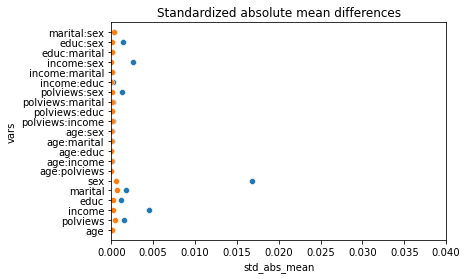

In [34]:
# Plotting 
result = result.sort_index( ascending=False)
fig, ax = plt.subplots() 
#x = np.arange(0, 10, 1)
plt.xlim(0, 0.04)
sns.scatterplot(data=result, x="std_abs_mean", y="vars", ax =ax)
sns.scatterplot(data=result, x="std_abs_mean_adj", y="vars", ax =ax)
plt.title("Standardized absolute mean differences")

Note above how in particular `age` and `polviews` -- the variables we chose to introduce imbalance in Section (3.3) -- are far from balanced before adjustment, as are other variables that correlate with them. 

In addition to the above, we can check the entire distribution of covariates (and their transformations). The next snippet plots histograms for treated and untreated individuals with and without adjustment. Note how the adjusted histograms are very similar -- that is what we should expect. 

In [35]:
data_2 = matrix[["age", "polviews", "age:polviews", "educ",]]
# merge covariates and treatment variable  
data_3 = pd.merge(data_2, W, right_index = True,
               left_index = True)
data_3["IPW"] = np.where(data_3["w"] == 1, 1/e_hat, 1 / (1 - e_hat))

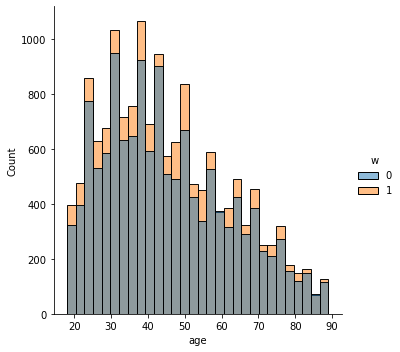

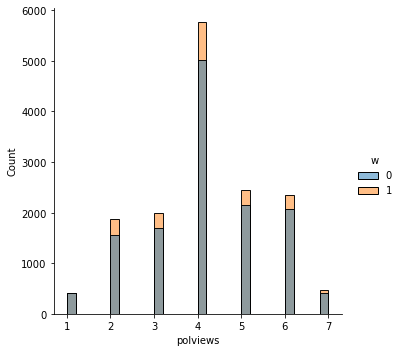

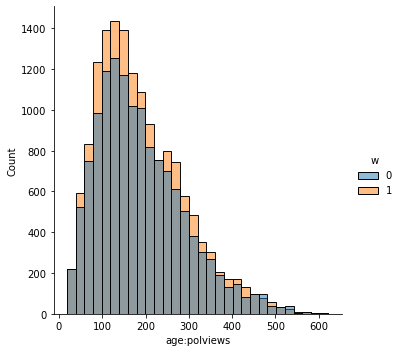

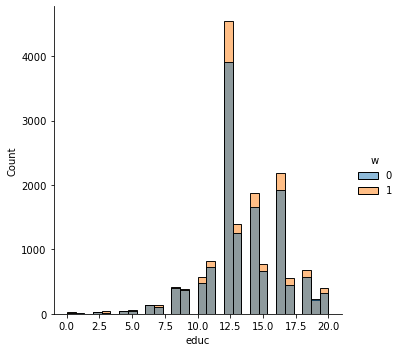

In [36]:
# Covariate histograms (unajusted)
sns.displot(data_3, x="age", hue="w", bins=30)
sns.displot(data_3, x="polviews", hue="w", bins=30)
sns.displot(data_3, x="age:polviews", hue="w", bins=30)
sns.displot(data_3, x="educ", hue="w", bins=30)

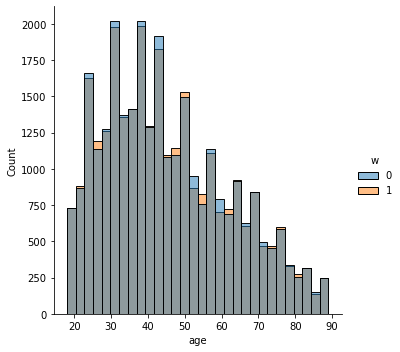

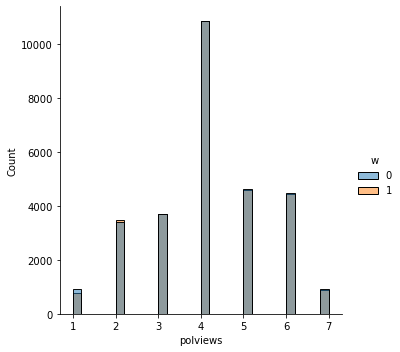

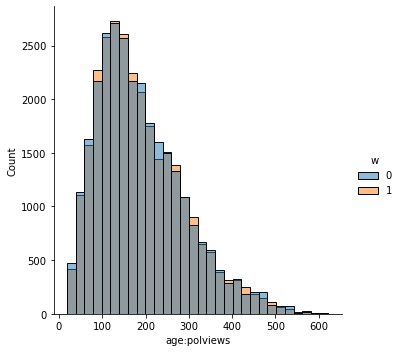

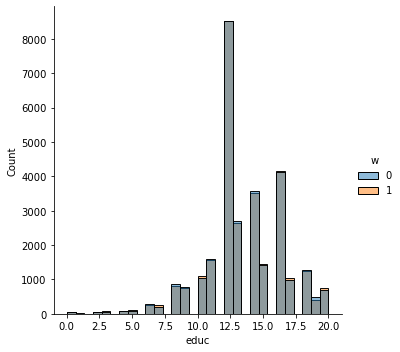

In [37]:
# Covariate histograms (ajusted)
sns.displot(data_3, x="age", hue="w", bins= 30, weights=np.array(data_3["IPW"]) )
sns.displot(data_3, x="polviews", hue="w", bins= 30, weights=np.array(data_3["IPW"]) )
sns.displot(data_3, x="age:polviews", hue="w", bins= 30, weights=np.array(data_3["IPW"]) )
sns.displot(data_3, x="educ", hue="w", bins= 30, weights=np.array(data_3["IPW"]) )

There exist other types of balance checks. We recommend checking out the `R` package `cobalt`. This [vignette](https://cran.r-project.org/web/packages/cobalt/vignettes/cobalt.html) is a good place to start.

### Assessing overlap

It's also important to check the estimated propensity scores. If they seem to cluster at zero or one, we should expect IPW and AIPW estimators to behave very poorly. Here, the propensity score is trimodal because of our sample modification procedure in Section (3.3): some observations are untouched and therefore remain with assignment probability $0.5$, some are dropped (kept) with probability 15\% (85\%).

Text(0.5, 1.0, 'Estimated propensity scores (causal forest)')

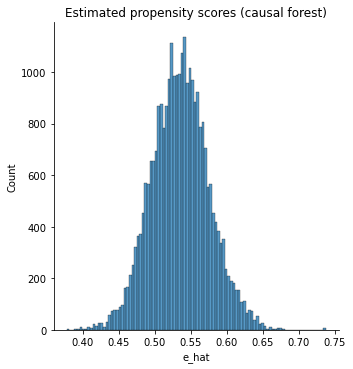

In [38]:
g = sns.displot(e_hat, bins=100)
g.set_axis_labels("e_hat")
# g.set_titles("Estimated propensity scores (causal forest)")
plt.title("Estimated propensity scores (causal forest)")

When overlap fails, the methods described above will not produce good estimates. In that case, one may consider changing the estimand and targeting the average treatment effect _on the treated_ (ATT) $\mathbf{E}[Y_i(1) - Y_i(0) | W_i=1]$, or trimming the sample and focusing on some subgroup $G_i$ with bounded propensity scores $\mathbf{E}[Y_i(1) - Y_i(0) | G_i]$, as discussed in  
[Crump, Hotz, Imbens and Mitnik (Biometrika, 2009)](https://academic.oup.com/biomet/article/96/1/187/235329?login=true).

## Further reading

Besides the references noted in the text, for more information on the theory behind the estimators studied in this tutorial we recommend Stefan Wager’s [lecture notes](https://web.stanford.edu/~swager/stats361.pdf) (Lectures 1-4 and 7).